# 潜在変数 Model
複数の異なる確率分布に従う確率変数の Data が同時に含まれている状況で、複数の確率分布の「混在比率」と確率分布の Parameter を同時に求める難易度の高い推論。

## 問題設定
Iris-dataset で setosa 以外の２種類のみを利用し、花の種別情報なしで、２種類の花の統計的特徴を推論する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas as pd

np.set_printoptions(precision=3, floatmode='fixed')
pd.options.display.float_format = '{:.3f}'.format

In [2]:
import pymc as pm
import arviz as az

print(f"PyMC version: {pm.__version__}")
print(f"ArViz version: {az.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


PyMC version: 5.7.2
ArViz version: 0.15.1


In [3]:
# Iris-dataset の読み込み
df = sns.load_dataset("iris")

df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa
...,...,...,...,...,...
145,6.700,3.000,5.200,2.300,virginica
146,6.300,2.500,5.000,1.900,virginica
147,6.500,3.000,5.200,2.000,virginica
148,6.200,3.400,5.400,2.300,virginica


In [4]:
# species の分布
df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [5]:
# 分析対象Data の抽出
df_target = df[df['species'] != 'setosa']
df_target.reset_index(drop=True, inplace=True)

x_petal_width = df_target['petal_width'].values

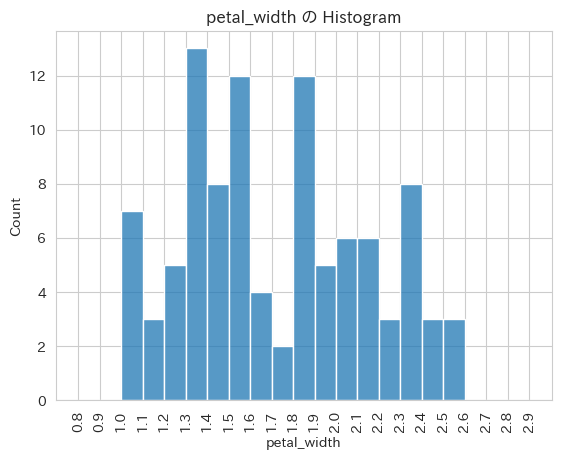

In [6]:
# 分析対象Data を色分けなしに Histogram表示
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(x=x_petal_width, bins=bins)
ax.set_xlabel('petal_width')
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('petal_width の Histogram')
ax.set_xticks(bins)
plt.show()

Data分布には２つの Peak がありそう。
- ２つの異なる正規分布に従う確率変数の Data が同時に含まれている、という仮説がおける。
- 分布の裾は重なっていて、どちらの Gropu の Data がどいういう比率なのかを判断することからして困難。

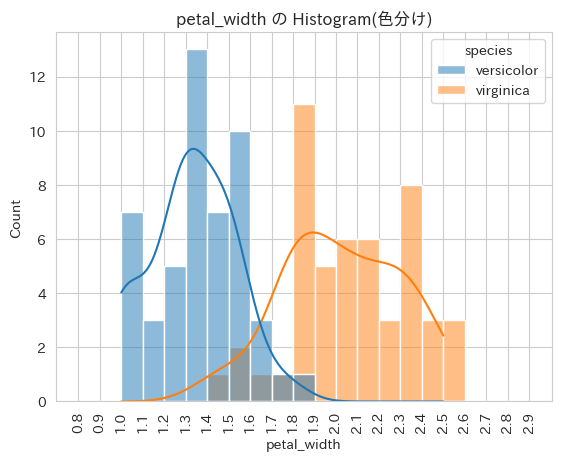

In [7]:
# petal_width の Histogram描画（花の種類で色分け）
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(data=df_target,
             bins=bins,
             x='petal_width',
             hue='species',
             kde=True)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('petal_width の Histogram(色分け)')
ax.set_xticks(bins)
plt.show()

In [8]:
# 確率Model 定義

# 変数の初期設定
n_components = 2  # 何種類の正規分布Model があるか
n = x_petal_width.shape  # 観測Data 件数

model = pm.Model()

with model:
    # X の観測値を ConstantData として定義
    x_data_petal_width = pm.ConstantData('x_data', x_petal_width)

    # p: 存在変数が１の値をとる確率
    p = pm.Uniform('p', lower=0.0, upper=1.0)

    # s: 潜在変数 p の確率値をもとに 0, 1 のいずれかの値を返す
    s = pm.Bernoulli('s', p=p, shape=n)

    # mus: ２つの花の種類ごとの平均値
    mus = pm.Normal('mus', mu=0.0, sigma=10.0, shape=n_components)

    # taus: ２つの花の種類ごとのバラツキ
    # 標準偏差 sigma との間には tau = 1 / (sigma*sigma) の関係がある
    taus = pm.HalfNormal('taus', sigma=10.0, shape=n_components)

    # Graph描画など分析で sigma が必要なため、taus から sigmas を求めておく
    sigmas = pm.Deterministic('sigmas', 1 / pm.math.sqrt(taus))

    # 各観測値ごとに潜在変数から mu と tau を求める
    mu = pm.Deterministic('mu', mus[s])
    tau = pm.Deterministic('tau', taus[s])

    # 正規分布に従う確率変数 x_obs の定義
    x_obs = pm.Normal('x_obs', mu=mu, tau=tau, observed=x_data_petal_width)

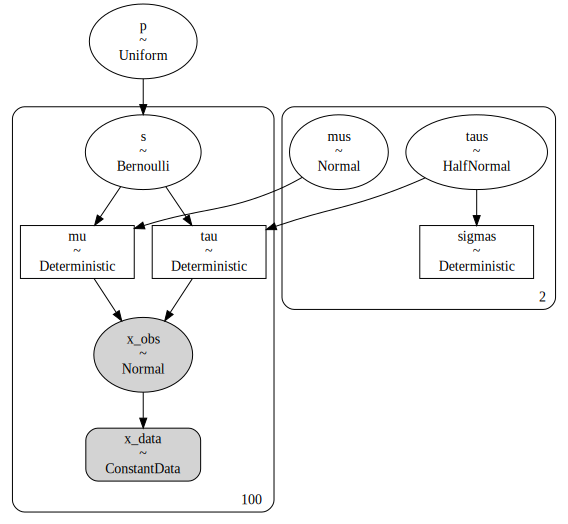

In [9]:
# 確率Model構造の可視化
pm.model_to_graphviz(model)

#### 潜在変数Model
- Index は、確率変数。（個別の Sample毎に変化する変数）
- 上記が「潜在変数」（観測値を持たない、外部から見ることのできない確率変数）と呼ばれている。

In [10]:
# Sampling
with model:
    idata = pm.sample(chains=1, draws=2000, target_accept=0.99, random_seed=42)
    # label-switch を防ぐため chains=1 を指定
    # chains を減らしたことで Sample数が半分になるので draws=2000 で調整

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 35 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


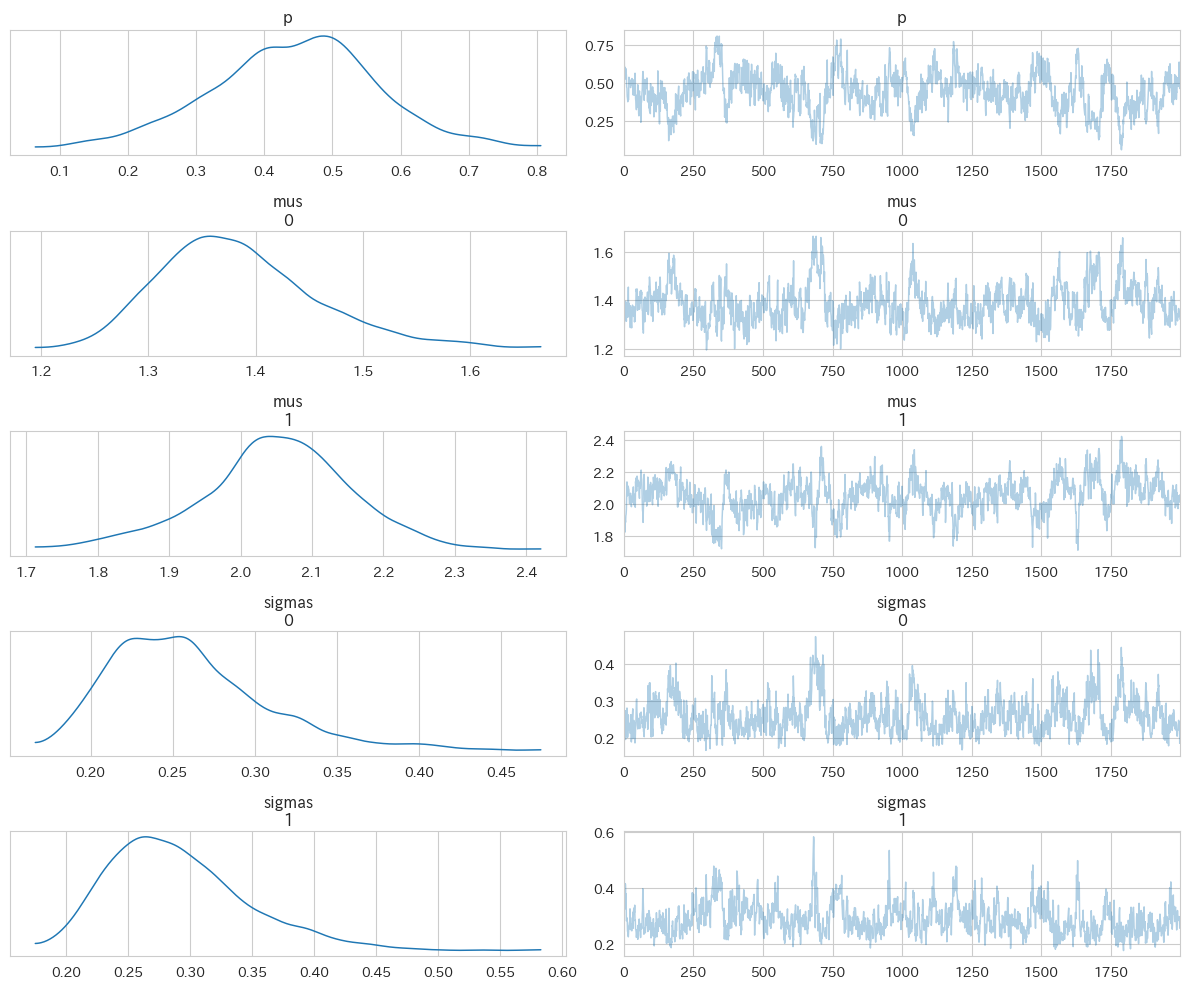

In [11]:
# 推論結果の確認
az.plot_trace(idata, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout()
plt.show()

#### p
- 今回の潜在変数は 0 or 1 の値をとるベルヌーイ分布。
- ２つの Sample数は同数ある。

上記より p の値は 0.5 程度になると想定される。
Graph より p=0.5 のあたりに Peak がありそうなので結果としては妥当。

#### mus
- mus\[0]: 1.2 ~ 1.6
- mus\[1]: 1.7 ~ 2.4

と変化の範囲がきれいに分かれている。
>もし Label-switch が起こると、２つの領域の値に重なりが出たり、分布の Peak が２カ所になったりする。

#### sigmas
- sigmas\[0], sigmas\[1] どちらの確率分布も 0.25 程度を中心としたきれいな分布になっている。
- 標準偏差 0.25 程度という値も今回の観測値Data から妥当。

# 以上より、うまく Bayes推論できている。

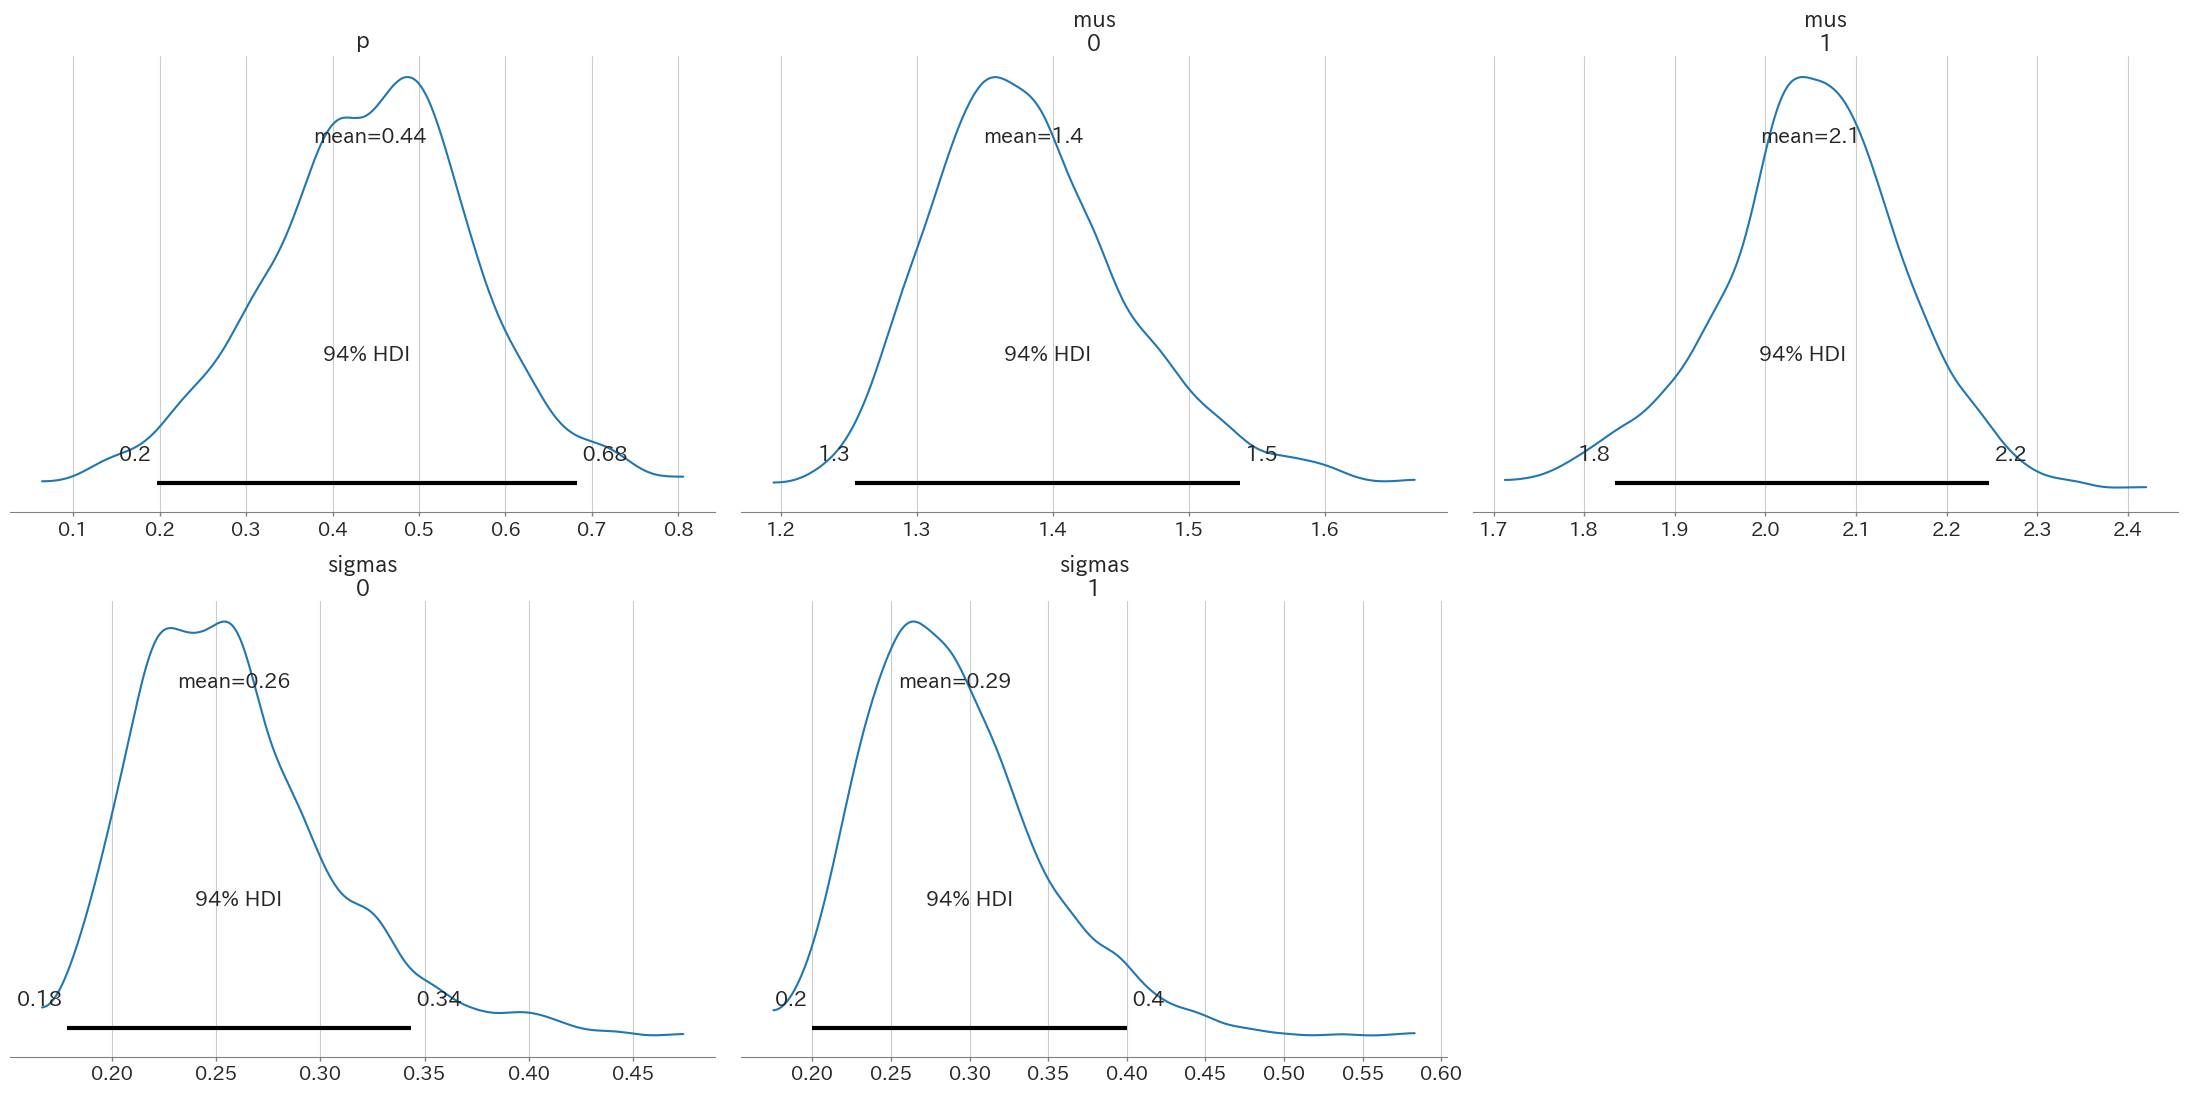

In [12]:
# 各確率変数の事後分布を確認
az.plot_posterior(idata, var_names=['p', 'mus', 'sigmas'])
plt.tight_layout()
plt.show()

- p はほぼ 0.5程度と妥当な値
- mus は、最初の要素の予測値と２番目の要素の予測値でかぶりなく、きれいに分離できている。

In [13]:
# 統計情報
summary = az.summary(idata, var_names=['p', 'mus', 'sigmas'])
summary

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.443,0.125,0.197,0.682,0.015,0.011,66.000,148.000,NaN
mus[0],1.386,0.077,1.255,1.538,0.009,0.006,82.000,113.000,NaN
mus[1],2.050,0.107,1.834,2.247,0.013,0.009,69.000,135.000,NaN
sigmas[0],0.259,0.047,0.178,0.343,0.005,0.004,106.000,139.000,NaN
sigmas[1],0.291,0.056,0.200,0.400,0.006,0.004,88.000,294.000,NaN


r_hat は、２以上の Sample直系列があってはじめて計算可能なため、NaN で正常。

In [14]:
# Histogram と正規分布関数の重ね描き

# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu) / sigma) ** 2 / 2) / (np.sqrt(2 * np.pi) * sigma)


# 推論結果から各Parameters の平均値を取得
mean = summary['mean']

# mu の平均値取得
mean_mu0 = mean['mus[0]']
mean_mu1 = mean['mus[1]']

# sigma の平均値取得
mean_sigma0 = mean['sigmas[0]']
mean_sigma1 = mean['sigmas[1]']



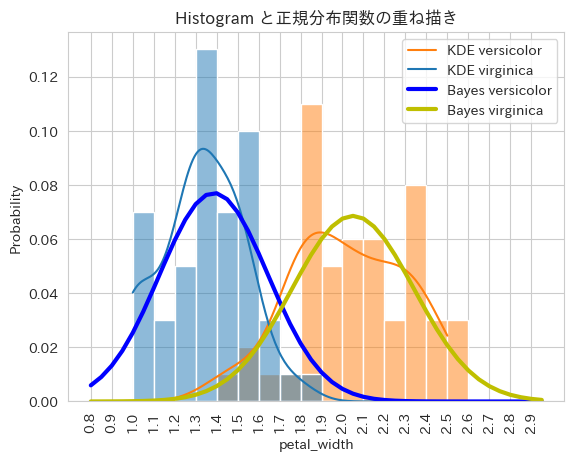

In [15]:
# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

# Graph描画
bins = np.arange(0.8, 3.0, delta)
fig, ax = plt.subplots()
sns.histplot(data=df_target,
             bins=bins,
             x='petal_width',
             hue='species',
             kde=True,
             ax=ax,
             stat='probability')
ax.get_lines()[0].set_label('KDE versicolor')
ax.get_lines()[1].set_label('KDE virginica')
ax.plot(x, y0, c='b', lw=3, label='Bayes versicolor')
ax.plot(x, y1, c='y', lw=3, label='Bayes virginica')
ax.set_xticks(bins)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('Histogram と正規分布関数の重ね描き')
plt.legend()
plt.show()

Bayes推論による正規分布関数の Graph は、花の種別の情報なしに推測した結果。
この結果がほぼ一致しているため、Bayes推論による予測が正しくできたといえる。

## 潜在変数の確率分布
確率Model構築の過程で出てきた、しかし実態がまったくわかっていない「潜在変数 s」の振る舞いを確認する。

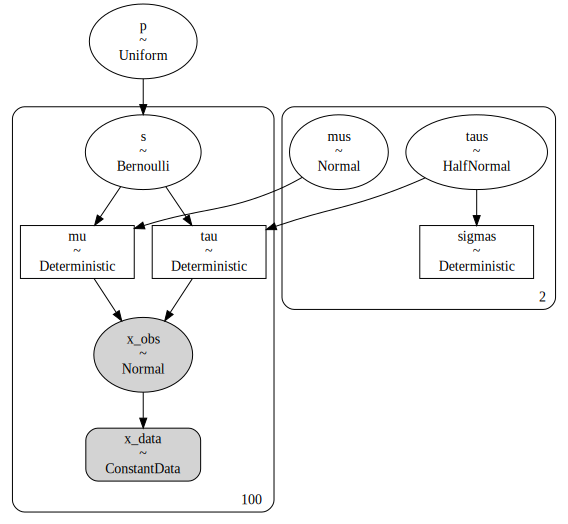

In [16]:
pm.model_to_graphviz(model)

- 潜在変数`s` は、観測値ごとに個別の確率分布を持っている
    = 観測値 `x_data` の値に応じて、潜在変数値`s` が０になりやすい場合や１になりやす場合があるはず。

所得済みの Sample値 `idata` から調査する.。

In [17]:
# petal_width の値が 1.0, 1.5, 1.7, 2.0, 2.5 の Index を調査
value_list = [1.0, 1.5, 1.7, 2.0, 2.5]

df_heads = pd.DataFrame(None)

# petal_width の値が 1.0 から 2.5 までそれぞれの値である先頭の行を抽出
for value in value_list:
    # df_target から petal_width の値が value である行のみ抽出
    w = df_target[df_target['petal_width'] == value]
    
    # 先頭の１行を抽出し、df_heads に連結
    df_heads = pd.concat([df_heads, w.head(1)], axis=0)

df_heads

,sepal_length,sepal_width,petal_length,petal_width,species
7,4.900,2.400,3.300,1.000,versicolor
1,6.400,3.200,4.500,1.500,versicolor
27,6.700,3.000,5.000,1.700,versicolor
60,6.500,3.200,5.100,2.000,virginica
50,6.300,3.300,6.000,2.500,virginica


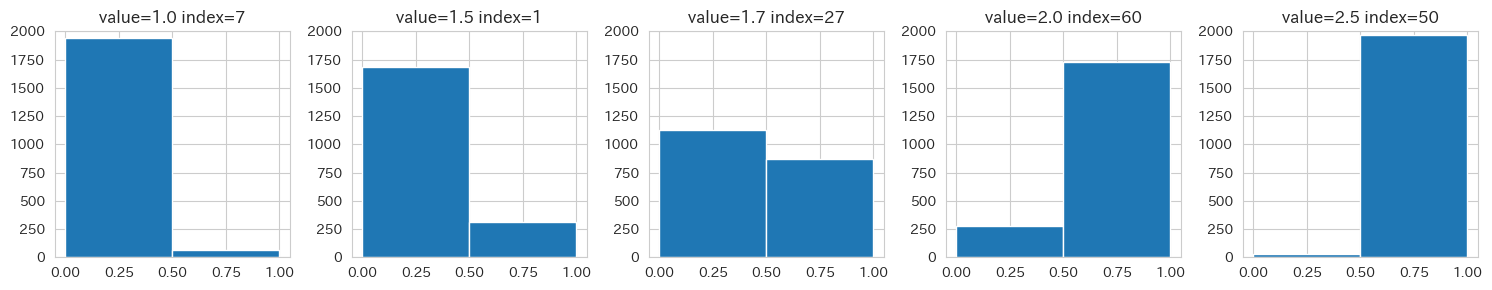

In [19]:
# df_heads の Index を抽出
indexes, n_indexes = df_heads.index, len(df_heads)

# 潜在変数 s の Sample値から、indexes の値を抽出
s_values = idata.posterior['s'][:, :, indexes].values.reshape(-1, n_indexes).T

# それぞれの Case で Histogram の描画
vlist = df_heads['petal_width']
fig, axes = plt.subplots(1, n_indexes, figsize=(15, 3))
for ax, item, value, index in zip(axes, s_values, vlist, indexes):
    f = pd.DataFrame(item)
    f.hist(ax=ax, bins=2)
    ax.set_ylim(0, 2000)
    ax.set_title(f'value={value} index={index}')

plt.tight_layout()
plt.show()

`s`(潜在変数)は、`value` の値が大きくなるにつれて、数値が１なる比率が高くなっている。

### 潜在変数Modelにおける Bayes推論
- 潜在変数Model は、技術的観点で面白く、いかにも Bayes推論らしい手法。
- 難易度は高く、実Data ではなかなか意図した動きを作ることが出来ない確率Model.
- 一般的には、潜在変数Model での推論は、推論対象の変数が大量にある場合が多いため、確率Model を注意深く設計しなければならない。

## 意図しない結果になる確率Model
`tau` ではなく `sigma` でバラツキを入力してみる。

In [22]:
# 確率Model を定義

n_components = 2
n = x_petal_width.shape

model_sigma_pattern = pm.Model()

with model_sigma_pattern:
    x_data_petal_width = pm.ConstantData('x_data_petal_width', x_petal_width)  # x の観測値を ConstantData として定義
    p = pm.Uniform('p', lower=0.0, upper=1.0)  # p: 潜在変数が１の値をとる確率
    s = pm.Bernoulli('s', p=p, shape=n)  # s: 潜在変数 p の確率値をもとに 0, 1 のいずれかの値を返す
    mus = pm.Normal('mus', mu=0.0, sigma=10.0, shape=n_components)  # ２つの花の種類ごとの平均値
    sigmas = pm.HalfNormal('sigmas', sigma=10.0, shape=n_components)  # ２つの花の種類ごとのバラツキ

    # 観測値毎に潜在変数から平均値と標準偏差を求める
    mu = pm.Deterministic('mu', mus[s])
    sigma = pm.Deterministic('sigma', sigmas[s])

    # 正規分布により x(petal_width) の値を求める
    x_obs = pm.Normal('x_obs', mu=mu, sigma=sigma, observed=x_data_petal_width)

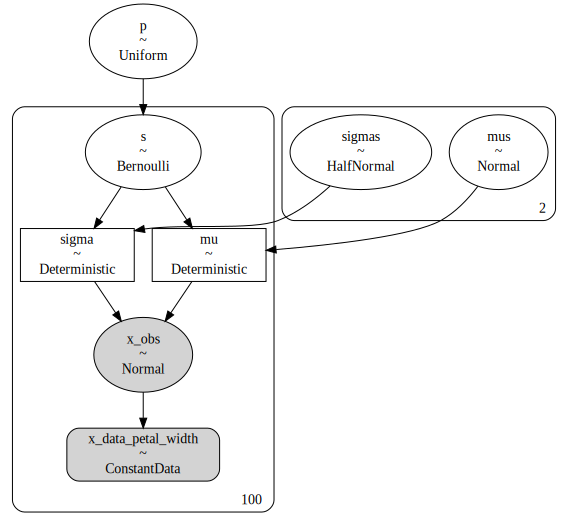

In [23]:
pm.model_to_graphviz(model_sigma_pattern)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, sigmas]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 46 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


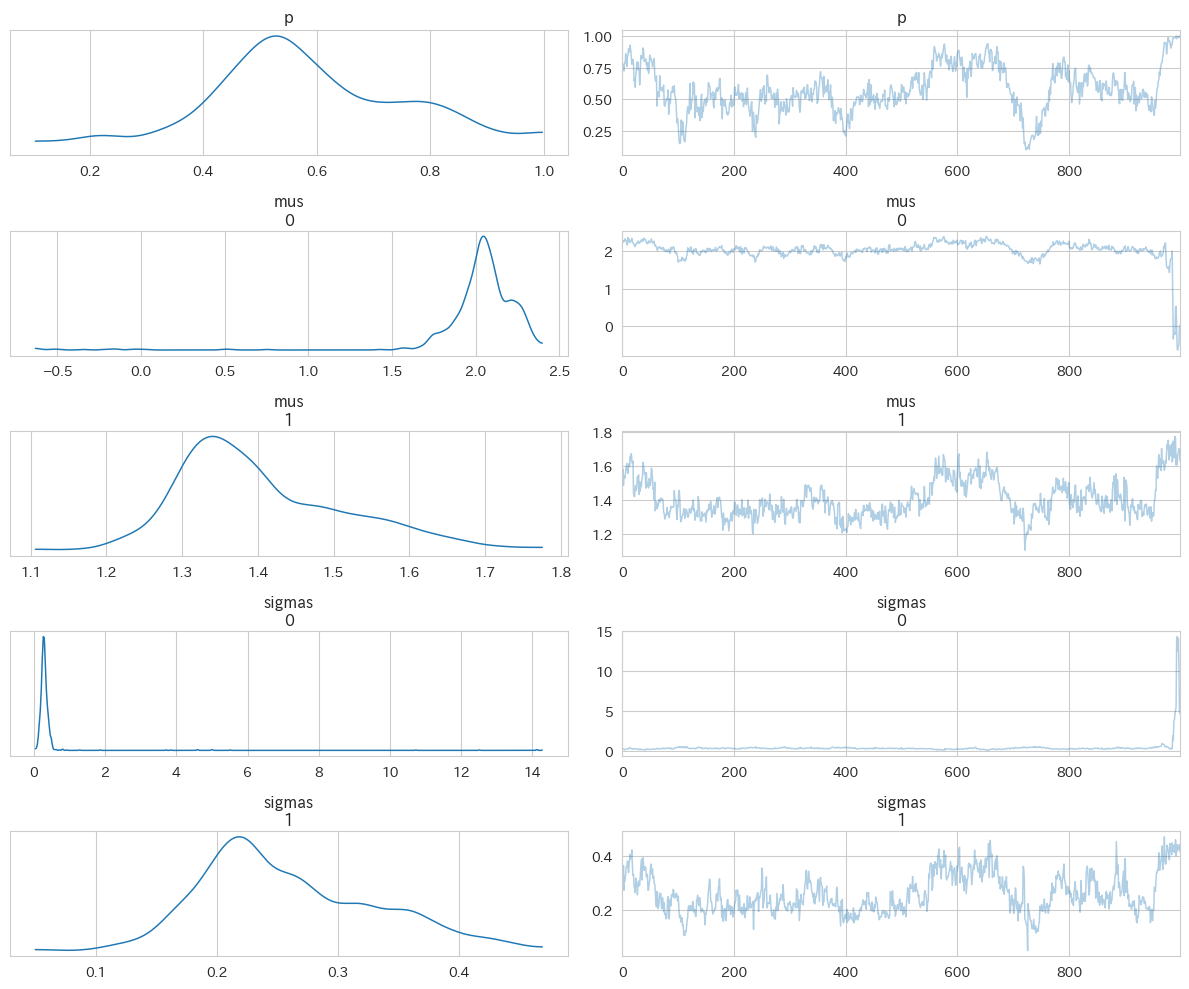

In [24]:
# Sampling & 結果分析
with model_sigma_pattern:
    idata_sigma_pattern = pm.sample(random_seed=42, chains=1, target_accept=0.998)

az.plot_trace(idata_sigma_pattern, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout()
plt.show()

Bayes推論がうまくいかない。

## Label-switch が起きない確率Model

In [25]:
# 変数の初期設定

n_components = 2  # 何種類の正規分布Model があるか
n = x_petal_width.shape  # 観測Data 件数

In [26]:
# Label-switch が起きないように確率Model を定義

model_non_label_switch = pm.Model()

with model_non_label_switch:
    x_data_petal_width = pm.ConstantData('x_data_petal_width', x_petal_width)  # x の観測値を ConstantData として定義
    p = pm.Uniform('p', lower=0.0, upper=1.0)  # p: 潜在変数が１の値をとる確率
    s = pm.Bernoulli('s', p=p, shape=n)  # s: 潜在変数。p の確率値のもと 0, 1 のいずれかの値を返す

    # mus: ２つの花の種類ごとの平均値
    mu0 = pm.HalfNormal('mu0', sigma=10.0)  # 半正規分布の確率変数として定義
    delta0 = pm.HalfNormal('delta0', sigma=10.0)  # 半正規分布の確率変数として定義
    mu1 = pm.Deterministic('mu1', mu0 + delta0)  # mu0 + delta0 の計算式により定義
    mus = pm.Deterministic('mus', pm.math.stack([mu0, mu1]))  # ２要素の配列として確率変数 mus として定義
    # pm.math.stack関数を使用することで、常に mus[0] < mus[1] の関係が成り立つようなり、Label-switch の発生を防止
    
    # taus: ２つの花の種類ごとのバラツキ
    # 標準偏差 sigma とおｎ間には taus = 1 / (sigmas * sigmas) の関係がある
    taus = pm.HalfNormal('taus', sigma=10.0, shape=n_components)

    # Graph描画など分析で sigmas が必要なため、taus から sigmas を求めておく
    sigmas = pm.Deterministic('sigmas', 1 / pm.math.sqrt(taus))

    # 各観測値ごに潜在変数から mu と tau を求める
    mu = pm.Deterministic('mu', mus[s])
    tau = pm.Deterministic('tau', taus[s])

    # 正規分布に従う確率変数 x_obs の定義
    x_obs = pm.Normal('x_obs', mu=mu, tau=tau, observed=x_data_petal_width)

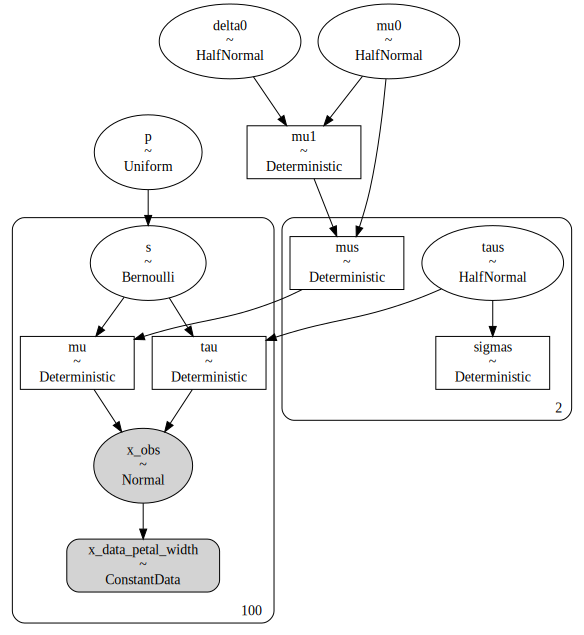

In [30]:
# 確率Model構造の可視化
pm.model_to_graphviz(model_non_label_switch)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu0, delta0, taus]
>BinaryGibbsMetropolis: [s]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


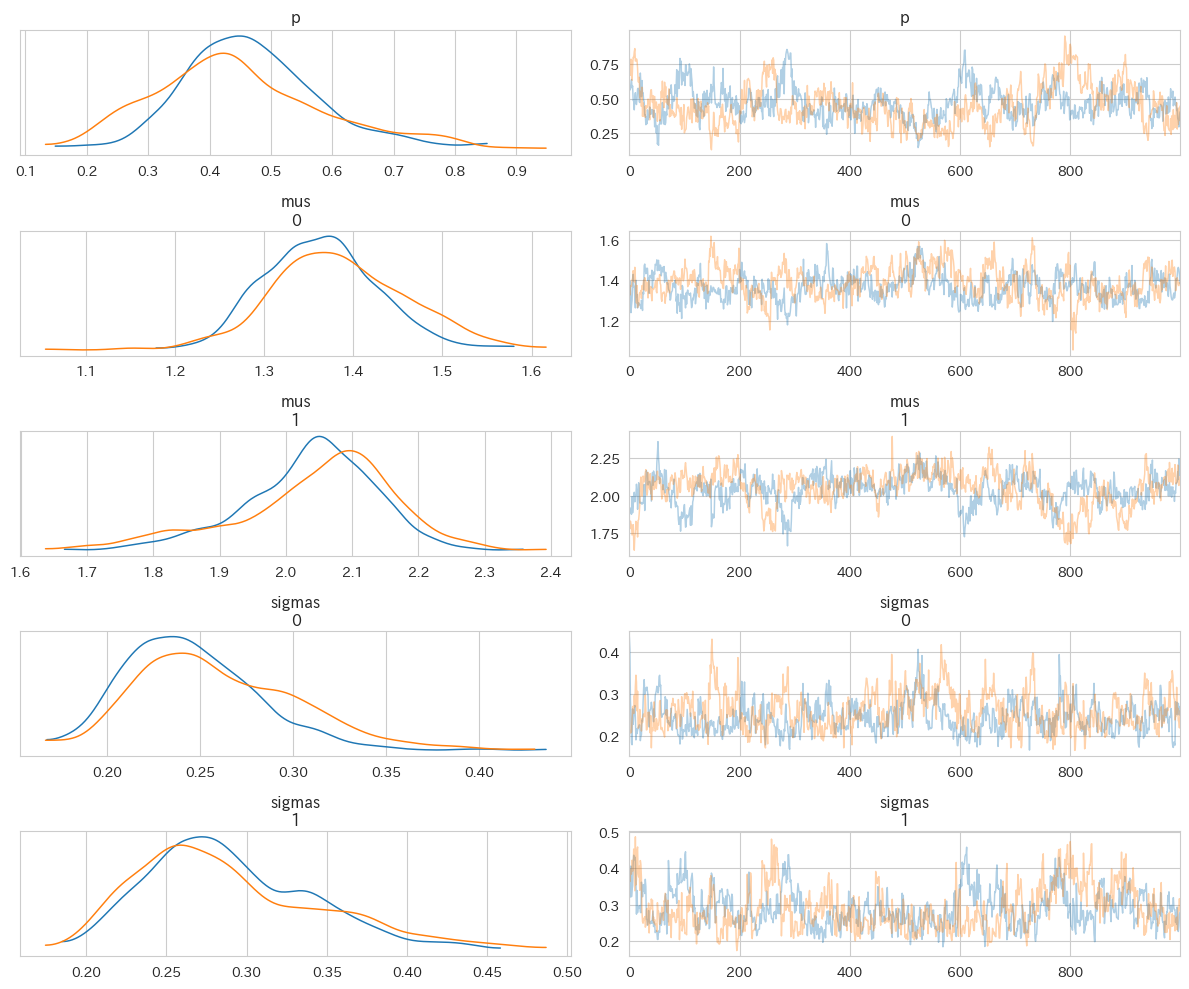

In [31]:
# Sampling & 結果分析
with model_non_label_switch:
    idata_non_label_switch = pm.sample(random_seed=42, chains=2, target_accept=0.999)

az.plot_trace(idata_non_label_switch, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout()
plt.show()

５つの左側の分布Graph において２つの Sample-data系列の波形がほぼ重なっている。
=> Label-switch の問題を起こさずに潜在変数Model の Bayes推論ができている。

In [32]:
summary_non_label_switch = az.summary(idata_non_label_switch, var_names=['p', 'mus', 'sigmas'])
summary_non_label_switch

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.459,0.130,0.218,0.722,0.017,0.012,59.000,132.000,1.030
mus[0],1.375,0.071,1.251,1.518,0.008,0.006,81.000,177.000,1.020
mus[1],2.041,0.109,1.808,2.220,0.014,0.010,64.000,138.000,1.020
sigmas[0],0.253,0.041,0.186,0.332,0.004,0.003,113.000,294.000,1.030
sigmas[1],0.290,0.055,0.195,0.388,0.006,0.004,88.000,211.000,1.010


Graph描画

In [33]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-((x - mu) / sigma) ** 2 / 2) / (np.sqrt(2 * np.pi) * sigma)

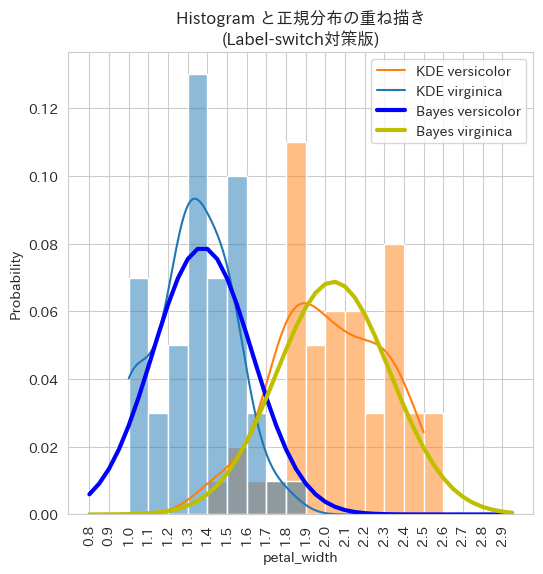

In [37]:
# 推論結果から各Parameters の平均値を取得
mean = summary_non_label_switch['mean']

# mu の平均値取得
mean_mu0 = mean['mus[0]']
mean_mu1 = mean['mus[1]']

# sigma の平均値取得
mean_sigma0 = mean['sigmas[0]']
mean_sigma1 = mean['sigmas[1]']

# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

# Graph描画
bins = np.arange(0.8, 3.0, delta)
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=df_target, bins=bins, x='petal_width', ax=ax, hue='species', kde=True, stat='probability')
ax.get_lines()[0].set_label('KDE versicolor')
ax.get_lines()[1].set_label('KDE virginica')
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('Histogram と正規分布の重ね描き\n(Label-switch対策版)')
ax.set_xticks(bins)
ax.plot(x, y0, c='b', lw=3, label='Bayes versicolor')
ax.plot(x, y1, c='y', lw=3, label='Bayes virginica')
plt.legend()
plt.show()